# Tutorial: LLM Experiments

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:**
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/lkk688/DeepDataMiningLearning/blob/master/docs/notebooks/CMPE-pytorch8-2025Fall.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lkk688/DeepDataMiningLearning/blob/master/docs/notebooks/CMPE-pytorch8-2025Fall.ipynb)       
**Author:** Kaikai Liu

In [ ]:
# ✅ Clone the repository
!git clone https://github.com/lkk688/DeepDataMiningLearning.git

# ✅ Change directory
%cd DeepDataMiningLearning

# ✅ Install flit and set environment flag to allow root install
!pip install flit
!FLIT_ROOT_INSTALL=1 flit install --symlink #This sets the environment variable FLIT_ROOT_INSTALL=1 inline so that flit will allow the install to proceed under root.

Cloning into 'DeepDataMiningLearning'...
remote: Enumerating objects: 4672, done.
remote: Counting objects: 100% (950/950), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 4672 (delta 886), reused 856 (delta 835), pack-reused 3722 (from 2)
Receiving objects: 100% (4672/4672), 192.35 MiB | 16.87 MiB/s, done.
Resolving deltas: 100% (3236/3236), done.
Updating files: 100% (413/413), done.
/content/DeepDataMiningLearning
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 4.4 MB/s eta 0:00:00
>Fetching list of valid trove classifiers                         I-flit.validate
Extras to install for deps 'all': {'.none', 'doc'}                I-flit.install
Installing requirements                                           I-flit.install
Symlinking DeepDataMiningLearning -> /usr/local/lib/python3.12/dist-packages/DeepDataMiningLearning  I-flit.install


In [ ]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [1]:
from DeepDataMiningLearning.llm.experiments import run_char_typing_experiment, run_qwen_finetune_experiment


🚀 ===== Character-Level Typing Experiment =====
📘 Building char-level typing dataset from 'npvinHnivqn/EnglishDictionary'...
📗 Building DataModule for task='lm' (tokenizer=char, seq_len=64)
📚 Loading Hugging Face dataset: 'npvinHnivqn/EnglishDictionary'
🧩 Detected configs: ['default']
✅ Using first available config: 'default'
📗 Using split: 'train'
🔤 Using text field(s): ['definition']
✅ Loaded 111,601 text entries from 'npvinHnivqn/EnglishDictionary' (config=default)
🧹 Cleaning raw text ...
✅ clean_texts: kept 124,088/124,090 lines (100.00% retained)
✅ Cleaned text length: 12,661,076 chars (124,088 lines kept)
🔤 Setting up tokenizer via TokenizerFactory: char
🔤 Building CharTokenizer ...
✅ CharTokenizer initialized | vocab_size=70 | pad_idx=0 | eos_idx=1 | unk_idx=2
✅ Tokenizer initialized | type=char | vocab_size=70 | pad_id=-100
🧩 Building LM dataset ...
🧩 Encoding text in chunks (chunk_size=50000) ...


Encoding: 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]


✅ Encoded 12,661,077 tokens total
⚙️  Using sliding window stride=1
📏 Built 12,661,013 sequences of len=64
🧾 Sample types: type(sequences[0])=<class 'list'>
  Inner element type: <class 'int'>
✅ Dataset split: 11,394,911 train | 1,266,102 val sequences

🔍 ===== DATASET INSPECTION =====
🧩 Task type: lm
📦 Train batches: 178045 | Validation batches: 19783
🔡 Vocabulary size: 70

🧩 --- Inspecting train batch 1/4 ---
🔹 Batch type: tuple (len=3)
  • tensor[0]: shape=(64, 63), dtype=torch.int64
  • tensor[1]: shape=(64, 63), dtype=torch.int64
  • tensor[2]: shape=(64,), dtype=torch.int64
  • Avg length: 63.0 | Min: 63 | Max: 63
  • Pad ratio: 0.00%  (pad_id=-100)
  • Label unique tokens: 35
  • Label vocab coverage: 50.00% of vocab
  • Label pad ratio: 0.00%
  • Top 5 label IDs: [(np.int64(4), 642), (np.int64(44), 361), (np.int64(40), 288), (np.int64(54), 276), (np.int64(59), 258)]

🗣️ Decoded examples:
   1. arp-pointed missile weapon, as an arrow.-anything resembling a 
      → target: rp-po

Epoch 1/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.3728 | acc=57.29% | ppl=3.95

✅ Epoch 1 done | val_loss=1.3728 | acc=57.29% | ppl=3.95
💾 Saved best model → outputs/checkpoints/traditionaltransformerlm_char_typing.pt


Epoch 2/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.3638 | acc=57.56% | ppl=3.91

✅ Epoch 2 done | val_loss=1.3638 | acc=57.56% | ppl=3.91
💾 Saved best model → outputs/checkpoints/traditionaltransformerlm_char_typing.pt


Epoch 3/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.3559 | acc=57.78% | ppl=3.88

✅ Epoch 3 done | val_loss=1.3559 | acc=57.78% | ppl=3.88
💾 Saved best model → outputs/checkpoints/traditionaltransformerlm_char_typing.pt


Epoch 4/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.3551 | acc=57.84% | ppl=3.88

✅ Epoch 4 done | val_loss=1.3551 | acc=57.84% | ppl=3.88
💾 Saved best model → outputs/checkpoints/traditionaltransformerlm_char_typing.pt


Epoch 5/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.3477 | acc=57.99% | ppl=3.85

✅ Epoch 5 done | val_loss=1.3477 | acc=57.99% | ppl=3.85
💾 Saved best model → outputs/checkpoints/traditionaltransformerlm_char_typing.pt


Epoch 6/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.3504 | acc=58.01% | ppl=3.86

✅ Epoch 6 done | val_loss=1.3504 | acc=58.01% | ppl=3.86
⚠️ No improvement for 1 epochs.

✅ Training complete.

🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.3504 | acc=58.01% | ppl=3.86

✅ TraditionalTransformerLM — loss=1.3504 | acc=58.01% | ppl=3.86


🧠 Training TransformerLM model...
🚀 Initializing modern TransformerLM (RMSNorm + RoPE + SwiGLU)
📅 Total training steps: 1068270
📉 Using ReduceLROnPlateau scheduler (adaptive LR on validation loss)

🔧 Using AMP: False | dtype: torch.bfloat16 | scaler: False

🚀 Training for 6 epochs on cuda (mode=teacher-forced)


Epoch 1/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.3684 | acc=57.52% | ppl=3.93

✅ Epoch 1 done | val_loss=1.3684 | acc=57.52% | ppl=3.93
💾 Saved best model → outputs/checkpoints/transformerlm_char_typing.pt


Epoch 2/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.3595 | acc=57.83% | ppl=3.89

✅ Epoch 2 done | val_loss=1.3595 | acc=57.83% | ppl=3.89
💾 Saved best model → outputs/checkpoints/transformerlm_char_typing.pt


Epoch 3/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.3514 | acc=58.06% | ppl=3.86

✅ Epoch 3 done | val_loss=1.3514 | acc=58.06% | ppl=3.86
💾 Saved best model → outputs/checkpoints/transformerlm_char_typing.pt


Epoch 4/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.3471 | acc=58.16% | ppl=3.85

✅ Epoch 4 done | val_loss=1.3471 | acc=58.16% | ppl=3.85
💾 Saved best model → outputs/checkpoints/transformerlm_char_typing.pt


Epoch 5/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.3457 | acc=58.26% | ppl=3.84

✅ Epoch 5 done | val_loss=1.3457 | acc=58.26% | ppl=3.84
💾 Saved best model → outputs/checkpoints/transformerlm_char_typing.pt


Epoch 6/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.3453 | acc=58.32% | ppl=3.84

✅ Epoch 6 done | val_loss=1.3453 | acc=58.32% | ppl=3.84
💾 Saved best model → outputs/checkpoints/transformerlm_char_typing.pt

✅ Training complete.

🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.3453 | acc=58.32% | ppl=3.84

✅ TransformerLM — loss=1.3453 | acc=58.32% | ppl=3.84


🧠 Training RNN model...
🧠 Initializing traditional RNN Language Model...
📅 Total training steps: 1068270
📉 Using ReduceLROnPlateau scheduler (adaptive LR on validation loss)

🔧 Using AMP: False | dtype: torch.bfloat16 | scaler: False

🚀 Training for 6 epochs on cuda (mode=teacher-forced)


Epoch 1/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.8388 | acc=44.55% | ppl=6.29

✅ Epoch 1 done | val_loss=1.8388 | acc=44.55% | ppl=6.29
💾 Saved best model → outputs/checkpoints/rnn_char_typing.pt


Epoch 2/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.8304 | acc=44.62% | ppl=6.24

✅ Epoch 2 done | val_loss=1.8304 | acc=44.62% | ppl=6.24
💾 Saved best model → outputs/checkpoints/rnn_char_typing.pt


Epoch 3/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.8272 | acc=44.84% | ppl=6.22

✅ Epoch 3 done | val_loss=1.8272 | acc=44.84% | ppl=6.22
💾 Saved best model → outputs/checkpoints/rnn_char_typing.pt


Epoch 4/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.8233 | acc=44.80% | ppl=6.19

✅ Epoch 4 done | val_loss=1.8233 | acc=44.80% | ppl=6.19
💾 Saved best model → outputs/checkpoints/rnn_char_typing.pt


Epoch 5/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.8217 | acc=44.94% | ppl=6.18

✅ Epoch 5 done | val_loss=1.8217 | acc=44.94% | ppl=6.18
💾 Saved best model → outputs/checkpoints/rnn_char_typing.pt


Epoch 6/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.8210 | acc=45.01% | ppl=6.18

✅ Epoch 6 done | val_loss=1.8210 | acc=45.01% | ppl=6.18
💾 Saved best model → outputs/checkpoints/rnn_char_typing.pt

✅ Training complete.

🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.8210 | acc=45.01% | ppl=6.18

✅ RNN — loss=1.8210 | acc=45.01% | ppl=6.18


🧠 Training LSTM model...
🧠 Initializing LSTM Language Model...
📅 Total training steps: 1068270
📉 Using ReduceLROnPlateau scheduler (adaptive LR on validation loss)

🔧 Using AMP: False | dtype: torch.bfloat16 | scaler: False

🚀 Training for 6 epochs on cuda (mode=teacher-forced)


Epoch 1/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.6169 | acc=50.80% | ppl=5.04

✅ Epoch 1 done | val_loss=1.6169 | acc=50.80% | ppl=5.04
💾 Saved best model → outputs/checkpoints/lstm_char_typing.pt


Epoch 2/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.6082 | acc=51.01% | ppl=4.99

✅ Epoch 2 done | val_loss=1.6082 | acc=51.01% | ppl=4.99
💾 Saved best model → outputs/checkpoints/lstm_char_typing.pt


Epoch 3/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.6023 | acc=51.12% | ppl=4.96

✅ Epoch 3 done | val_loss=1.6023 | acc=51.12% | ppl=4.96
💾 Saved best model → outputs/checkpoints/lstm_char_typing.pt


Epoch 4/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.5996 | acc=51.21% | ppl=4.95

✅ Epoch 4 done | val_loss=1.5996 | acc=51.21% | ppl=4.95
💾 Saved best model → outputs/checkpoints/lstm_char_typing.pt


Epoch 5/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.5981 | acc=51.36% | ppl=4.94

✅ Epoch 5 done | val_loss=1.5981 | acc=51.36% | ppl=4.94
💾 Saved best model → outputs/checkpoints/lstm_char_typing.pt


Epoch 6/6:   0%|          | 0/178045 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.5971 | acc=51.36% | ppl=4.94

✅ Epoch 6 done | val_loss=1.5971 | acc=51.36% | ppl=4.94
💾 Saved best model → outputs/checkpoints/lstm_char_typing.pt

✅ Training complete.

🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/19783 [00:00<?, ?it/s]

✅ Eval complete | loss=1.5971 | acc=51.36% | ppl=4.94

✅ LSTM — loss=1.5971 | acc=51.36% | ppl=4.94

💾 Saved experiment configuration and results → outputs/experiment_config_20251107_001739.json


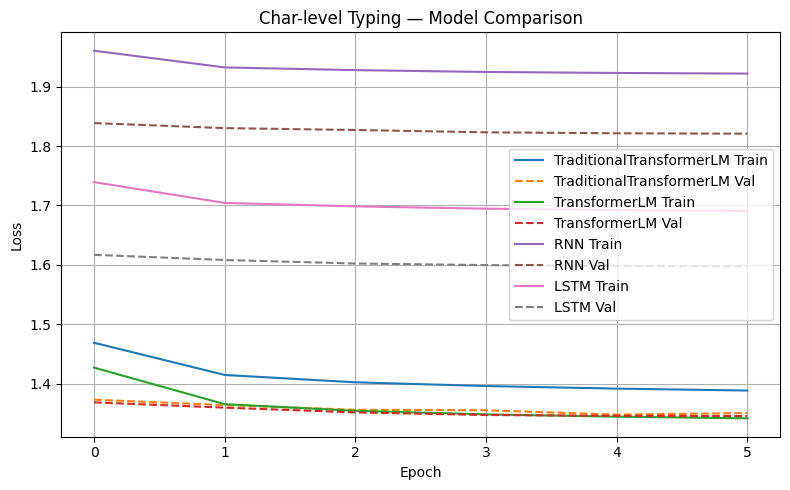


📊 Final Comparison Summary:
Model           Loss       Acc (%)    PPL       
---------------------------------------------
TraditionalTransformerLM 1.3504     58.01      3.86      
TransformerLM   1.3453     58.32      3.84      
RNN             1.8210     45.01      6.18      
LSTM            1.5971     51.36      4.94      

✅ ===== Experiment Complete =====


🔮 Running inference with TraditionalTransformerLM model...

🔮 Loading model checkpoint from: outputs/checkpoints/traditionaltransformerlm_char_typing.pt


ValueError: ❌ Need either data.vocab_size or explicit vocab_size for model construction.

In [2]:
run_char_typing_experiment()

In [ ]:
from DeepDataMiningLearning.llm.experiments import run_tokenizer_comparison_experiment
run_tokenizer_comparison_experiment(
    hf_name="npvinHnivqn/EnglishDictionary",
    seq_len=128,
    batch_size=256, #32,
    epochs=3,  # Reduced for faster testing
    output_dir="outputs/tokenizer_comparison"
)


🚀 ===== Tokenizer Comparison Experiment =====
Testing TraditionalTransformerLM with 5 different tokenizers

🧠 Training TraditionalTransformerLM with sp-unigram tokenizer...
📘 Preparing custom tokenizer: custom:sp-unigram
🧠 Building CustomTokenizer (sp-unigram) → outputs/custom_sp-unigram_tokenizer
🚀 Training SentencePiece Unigram (byte_fallback=True) → outputs/custom_sp-unigram_tokenizer.model
⚠️ Warning: Could not prepare custom tokenizer sp-unigram: Internal: src/trainer_interface.cc(662) [(trainer_spec_.vocab_size()) == (model_proto->pieces_size())] Vocabulary size too high (5000). Please set it to a value <= 329.
Skipping sp-unigram tokenizer...

🧠 Training TraditionalTransformerLM with tiktoken-bpe tokenizer...
📘 Preparing custom tokenizer: custom:tiktoken-bpe
🧠 Building CustomTokenizer (tiktoken-bpe) → outputs/custom_tiktoken-bpe_tokenizer
✅ tiktoken loaded | encoding=cl100k_base | vocab_size≈100277
🧩 UTF-8 safe tokenizer initialized and reversible.
✅ Custom tokenizer tiktoken-b

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: outputs/custom_sp-unigram_tokenizer.txt
  input_format: 
  model_prefix: outputs/custom_sp-unigram_tokenizer
  model_type: UNIGRAM
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 2000000
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 1
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  un

🧩 Detected configs: ['default']
✅ Using first available config: 'default'
📗 Using split: 'train'
🔤 Using text field(s): ['definition']
✅ Loaded 111,601 text entries from 'npvinHnivqn/EnglishDictionary' (config=default)
🧹 Cleaning raw text ...
✅ clean_texts: kept 124,088/124,090 lines (100.00% retained)
✅ Cleaned text length: 12,661,076 chars (124,088 lines kept)
🔤 Setting up tokenizer via TokenizerFactory: custom:tiktoken-bpe
🧠 Building CustomTokenizer (tiktoken-bpe) → outputs/custom_tiktoken-bpe_tokenizer
✅ tiktoken loaded | encoding=cl100k_base | vocab_size≈100277
🧩 UTF-8 safe tokenizer initialized and reversible.
✅ Tokenizer initialized | type=custom:tiktoken-bpe | vocab_size=100277 | pad_id=-100
🧩 Building LM dataset ...
🧩 Encoding text in chunks (chunk_size=50000) ...


Encoding: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


✅ Encoded 3,107,525 tokens total
⚙️  Using sliding window stride=1
📏 Built 3,107,397 sequences of len=128
🧾 Sample types: type(sequences[0])=<class 'list'>
  Inner element type: <class 'int'>
✅ Dataset split: 2,796,657 train | 310,740 val sequences
✅ Dataset ready with tiktoken-bpe tokenizer (vocab_size: 100277)
🧩 Initializing Traditional Transformer (LayerNorm + GELU + AbsPos)
📅 Total training steps: 8193
📉 Using ReduceLROnPlateau scheduler (adaptive LR on validation loss)

🔧 Using AMP: True | dtype: torch.bfloat16 | scaler: False

🚀 Training for 3 epochs on cuda (mode=teacher-forced)


Epoch 1/3:   0%|          | 0/10924 [00:00<?, ?it/s]

In [ ]:
from DeepDataMiningLearning.llm.experiments import run_char_typing_experiment
run_char_typing_experiment()

In [2]:
!pip install jieba

  Using cached jieba-0.42.1.tar.gz (19.2 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for jieba: filename=jieba-0.42.1-py3-none-any.whl size=19314508 sha256=dbb1c7f0cb672446a2bff77009e1b169708d07f0367745e07c09d26cfacce6ad
  Stored in directory: /fs/atipa/home/010796032/.cache/pip/wheels/08/a1/a3/5c8ac52cc2f5782ffffc34c95c57c8e5ecb3063dc69541ee7c
Successfully built jieba


In [3]:
from DeepDataMiningLearning.llm.experiments import run_qwen_finetune_experiment
run_qwen_finetune_experiment()

🚀 Starting Qwen2.5-3B fine-tuning experiment...

📘 Building predictive typing dataset from 'OpenAssistant/oasst1'...
📗 Building DataModule for task='lm' (tokenizer=hf:Qwen/Qwen2.5-3B, seq_len=256)
📚 Loading Hugging Face dataset: 'OpenAssistant/oasst1'
🧩 Detected configs: ['default']
✅ Using first available config: 'default'
📗 Using split: 'train'
🔤 Using text field(s): ['text']
✅ Loaded 84,437 text entries from 'OpenAssistant/oasst1' (config=default)
🧹 Cleaning raw text ...
✅ clean_texts: kept 332,479/345,782 lines (96.15% retained)
✅ Cleaned text length: 37,859,735 chars (332,479 lines kept)
🔤 Setting up tokenizer via TokenizerFactory: hf:Qwen/Qwen2.5-3B
🤗 Loading Hugging Face tokenizer: Qwen/Qwen2.5-3B
🌐 Loading pretrained tokenizer from Hugging Face Hub: Qwen/Qwen2.5-3B
⚙️  Detected Byte-Level BPE family → verifying pre-tokenizer/decoder ...
✅ HFTokenizerWrapper initialized from 'Qwen/Qwen2.5-3B' | vocab_size=151643 | pad_id=151643
✅ Tokenizer initialized | type=hf:Qwen/Qwen2.5-3B |

Tokenizing: 100%|██████████| 333/333 [00:08<00:00, 37.97it/s]


✅ Encoded 9,331,777 tokens total (avg tokens/line ≈ 28)
⚙️  Using sliding window stride=64


`torch_dtype` is deprecated! Use `dtype` instead!


📏 Built 145,806 sequences of len=256
🧾 Sample types: type(sequences[0])=<class 'list'>
  Inner element type: <class 'int'>
✅ Dataset split: 131,225 train | 14,581 val sequences

🔍 ===== DATASET INSPECTION =====
🧩 Task type: lm
📦 Train batches: 65612 | Validation batches: 7291
🔡 Vocabulary size: 151,643

🧩 --- Inspecting train batch 1/1 ---
🔹 Batch type: tuple (len=3)
  • tensor[0]: shape=(2, 255), dtype=torch.int64
  • tensor[1]: shape=(2, 255), dtype=torch.int64
  • tensor[2]: shape=(2,), dtype=torch.int64
  • Avg length: 255.0 | Min: 255 | Max: 255
  • Pad ratio: 0.00%  (pad_id=151643)
  • Label unique tokens: 288
  • Label vocab coverage: 0.19% of vocab
  • Label pad ratio: 0.00%
  • Top 5 label IDs: [(np.int64(284), 16), (np.int64(11), 15), (np.int64(25), 14), (np.int64(2638), 12), (np.int64(13), 11)]

🗣️ Decoded examples:
   1. _file, output_path):with open(csv_file, "r") as file:reader = csv.reader(file)header = next(reader) # skip the header rowfor row in reader:name, url, ratin

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


✅ All parameters frozen.
✅ Unfroze layer 34.
✅ Unfroze layer 35.
✅ Unfroze language modeling head.

Trainable parameters check:
🔹 model.embed_tokens.weight is trainable.
🔹 model.layers.34.self_attn.q_proj.weight is trainable.
🔹 model.layers.34.self_attn.q_proj.bias is trainable.
🔹 model.layers.34.self_attn.k_proj.weight is trainable.
🔹 model.layers.34.self_attn.k_proj.bias is trainable.
🔹 model.layers.34.self_attn.v_proj.weight is trainable.
🔹 model.layers.34.self_attn.v_proj.bias is trainable.
🔹 model.layers.34.self_attn.o_proj.weight is trainable.
🔹 model.layers.34.mlp.gate_proj.weight is trainable.
🔹 model.layers.34.mlp.up_proj.weight is trainable.
🔹 model.layers.34.mlp.down_proj.weight is trainable.
🔹 model.layers.34.input_layernorm.weight is trainable.
🔹 model.layers.34.post_attention_layernorm.weight is trainable.
🔹 model.layers.35.self_attn.q_proj.weight is trainable.
🔹 model.layers.35.self_attn.q_proj.bias is trainable.
🔹 model.layers.35.self_attn.k_proj.weight is trainable.
🔹 

Eval valid: 100%|██████████| 7291/7291 [04:09<00:00, 29.17it/s]


✅ Eval complete | loss=2.0979 | acc=57.05% | ppl=8.15


✅ Qwen2.5-3B Original — loss=2.0979 | acc=57.05% | ppl=8.15

📅 Total training steps: 49209
🌊 Using CosineAnnealingWarmRestarts scheduler
🚀 Starting fine-tuning...

🔧 Using AMP: True | dtype: torch.bfloat16 | scaler: False

🚀 Training for 3 epochs on cuda (mode=teacher-forced)


Epoch 1/3: 100%|██████████| 65612/65612 [1:37:16<00:00, 11.24it/s, loss=1.9196, lr=1.000000e-05]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 7291/7291 [04:08<00:00, 29.36it/s]


✅ Eval complete | loss=1.9340 | acc=57.75% | ppl=6.92

✅ Epoch 1 done | val_loss=1.9340 | acc=57.75% | ppl=6.92
💾 Saved best model → checkpoints/qwen2.5_finetune.pt


Epoch 2/3: 100%|██████████| 65612/65612 [1:37:02<00:00, 11.27it/s, loss=1.9053, lr=9.140576e-06]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 7291/7291 [04:09<00:00, 29.28it/s]


✅ Eval complete | loss=1.9332 | acc=57.76% | ppl=6.91

✅ Epoch 2 done | val_loss=1.9332 | acc=57.76% | ppl=6.91
💾 Saved best model → checkpoints/qwen2.5_finetune.pt


Epoch 3/3: 100%|██████████| 65612/65612 [1:36:10<00:00, 11.37it/s, loss=1.9040, lr=6.890576e-06]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 7291/7291 [04:08<00:00, 29.35it/s]


✅ Eval complete | loss=1.9330 | acc=57.77% | ppl=6.91

✅ Epoch 3 done | val_loss=1.9330 | acc=57.77% | ppl=6.91
💾 Saved best model → checkpoints/qwen2.5_finetune.pt

✅ Training complete.

🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 7291/7291 [04:10<00:00, 29.08it/s]


✅ Eval complete | loss=1.9330 | acc=57.77% | ppl=6.91


✅ Qwen2.5-3B — loss=1.9330 | acc=57.77% | ppl=6.91



{'train_losses': [1.9195901036883887, 1.905311605955474, 1.903997703144872],
 'val_losses': [1.9340080515504652, 1.933167054018862, 1.9329514585577432],
 'final_loss': 1.9329514585577432,
 'final_acc': 0.5776646377239697,
 'final_ppl': 6.909874382718933}